# HDP zemí Evropy #

In [1]:
.libPaths('C:/Users/jkral/Desktop/skola/BI-PRS/libs') # change if needed
library(performance)
library(ggplot2)
library(olsrr)
library(moments)
library(cowplot)
library(vtable)
library(corrplot)
library(e1071)  
library(vioplot)
library(see)
library(tidyverse)
library(car)
library(glmnet)
library(lmtest)
library(eurostat)

options(width=160, repr.plot.width=11, repr.plot.height=7)


Attaching package: 'olsrr'


The following object is masked from 'package:datasets':

    rivers


Loading required package: kableExtra

corrplot 0.92 loaded


Attaching package: 'e1071'


The following objects are masked from 'package:moments':

    kurtosis, moment, skewness


Loading required package: sm

Package 'sm', version 2.2-5.7: type help(sm) for summary information

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


-- Attaching core tidyverse packages ---------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr     1.1.0     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.2     v tibble    3.1.8
v purrr     1.0.1     v tidyr     1.3.0
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter()     masks stats::filter()
x dplyr::group_rows() masks 

## Základní analýza dat

Načteme potřebná data z eurostatu a podíváme se na pár řádků z datasetu. Pokud jsou v datasetu nějaké *NA* hodnoty, odstraníme je.

In [2]:
df <- get_eurostat('nama_10_gdp')
df <- na.omit(df)
head(df)

unit,na_item,geo,time,values
<chr>,<chr>,<chr>,<date>,<dbl>
CLV05_MEUR,B1G,AT,2022-01-01,283441.0
CLV05_MEUR,B1G,BA,2022-01-01,11427.6
CLV05_MEUR,B1G,BE,2022-01-01,355710.6
CLV05_MEUR,B1G,BG,2022-01-01,31876.7
CLV05_MEUR,B1G,CH,2022-01-01,445107.4
CLV05_MEUR,B1G,CY,2022-01-01,18712.1


Vytáhneme si jen údaje pro náš rok a zahodíme všechny hodnoty, co se netýjkají jen jednotlivých států.

In [3]:
df <- df[df$na_item == "B1GQ",]
df <- df[df$unit == "CP_MEUR",]
df$time <- format(df$time, '%Y')
df <- df[df$time == "2018",]
df <- subset(df, nchar(geo) == 2)
df <- df[df$geo != "EA",]
colnames(df)[colnames(df) == "values"] ="HDP"
head(df)

unit,na_item,geo,time,values
<chr>,<chr>,<chr>,<chr>,<dbl>
CP_MEUR,B1GQ,AL,2018,12828.1
CP_MEUR,B1GQ,AT,2018,385274.1
CP_MEUR,B1GQ,BA,2018,17354.2
CP_MEUR,B1GQ,BE,2018,460050.8
CP_MEUR,B1GQ,BG,2018,56224.8
CP_MEUR,B1GQ,CH,2018,614304.4


Zůstalo nám 39 států. Hodnoty HDP jsou reprezentovány v milionech €. Již při pohledu na summary je vidět, že mezi státy je obrovský roudíl. Minimum 4 663 milionů a maximum 3 365 450 milionů. Nevyváženost je vidět i na rozdílu mezi mediánem a průměrem, který je přibližně 2.5x vyšší.

In [4]:
summary(df)

     unit             na_item              geo                time               values       
 Length:39          Length:39          Length:39          Length:39          Min.   :   4663  
 Class :character   Class :character   Class :character   Class :character   1st Qu.:  27543  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character   Median : 179558  
                                                                             Mean   : 454431  
                                                                             3rd Qu.: 465362  
                                                                             Max.   :3365450  

Na grafu jsou dobře vidět odlehlé hodnoty 5 nebjbohatších států. Jedná se popořadě o Německo, Velkou Británii, Francii, Itálii a Španělsko.

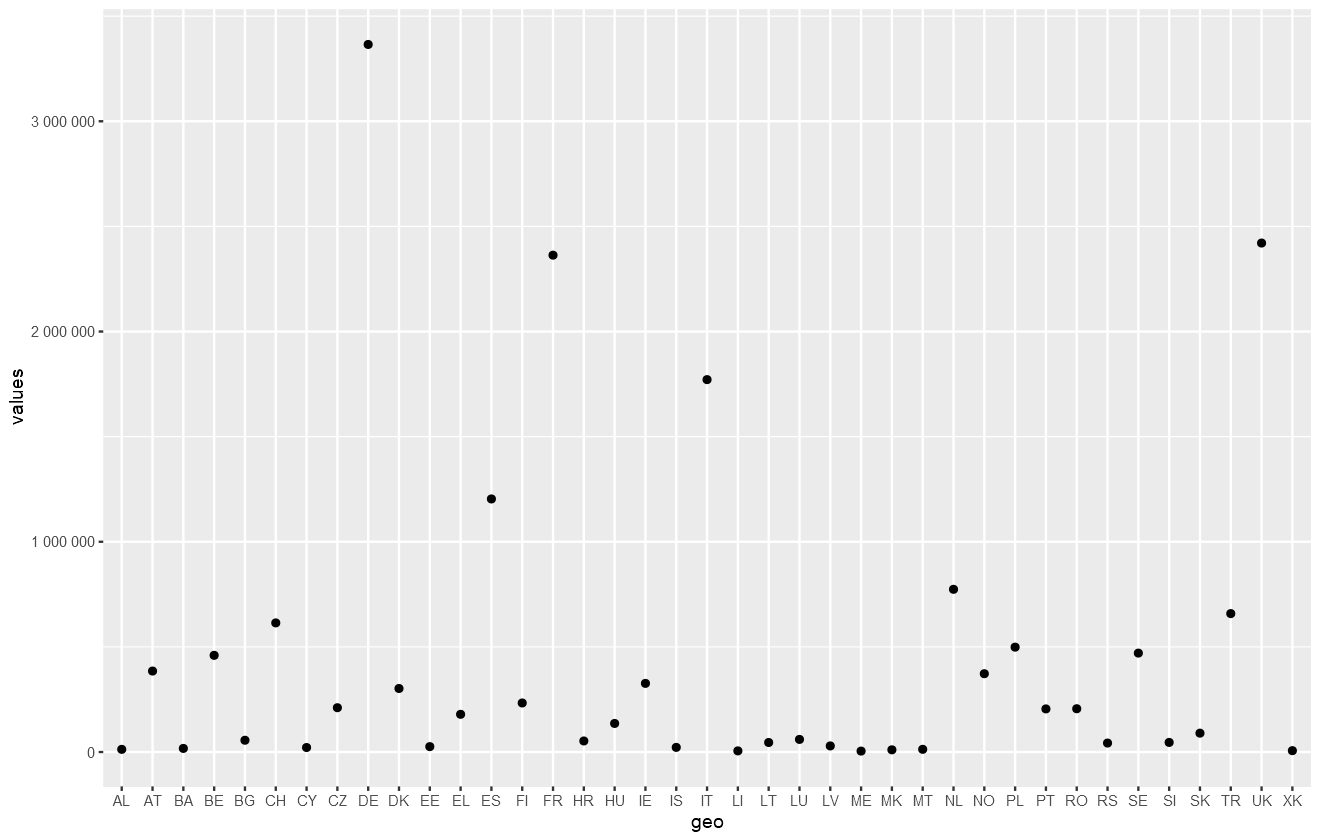

In [5]:
ggplot(df, aes(x=geo, y=HDP)) +
    geom_point() + 
    scale_y_continuous(labels=scales::label_number(scale = 1))

Graf si uspořádáme, aby rozdíly byly lépe vidět. Hodnoty nápadně připomínají exponenciálu.

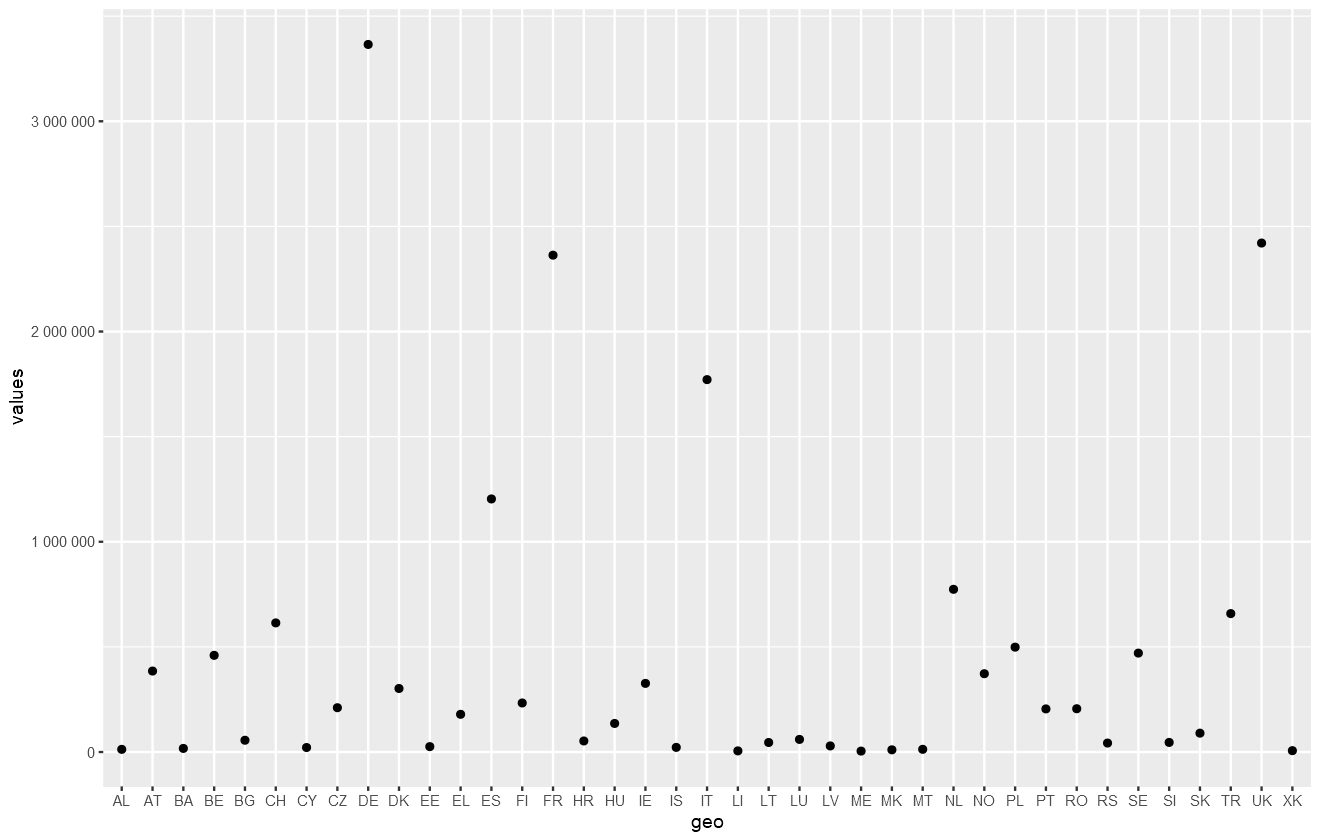

In [ ]:
ggplot(df, aes(reorder(geo, HDP), HDP)) +
    geom_point() + 
    scale_y_continuous(labels=scales::label_number(scale = 1))

Z grafu je patrné, že se nejspíše nebude jednat o normální rozdělení, ale svoji domněnku potvrdíme ještě testem.

In [6]:
shapiro.test(df$HDP)


	Shapiro-Wilk normality test

data:  df$values
W = 0.61977, p-value = 7.863e-09


Podezření se nám potvrdilo a zamítáme nulovou hypotézu, že se jedná o normální rozdělení.

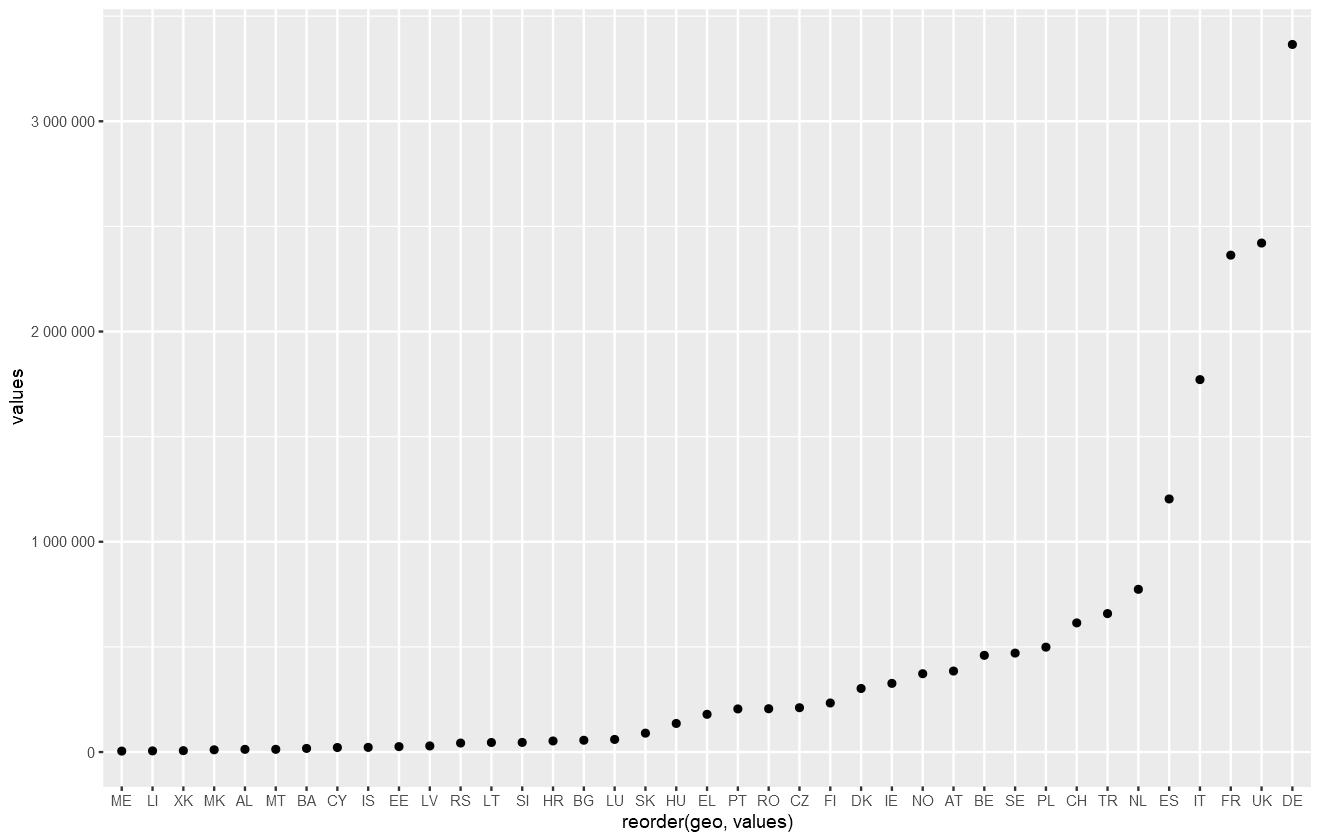

Jelikož je dataset v absolutních číslech, tak největší vliv bude mít počet obyvatel. Dále by velký vliv mohly mít data typu průměrný plat, průměrné dosažené vzdělání, členství v evropské unii. Velký vliv také bude mít export a tedy i přístup k moři.

Diskutujeme o tom co je important - počet obyvatel, použití €, přístup k moři, nějaká zemědělská věc co už jsem zapomněl co je 

## Úloha 2 ##

In [8]:
data <- get_eurostat(id = "demo_pjan")
data <- data[data$age == "TOTAL",]
data$time <- format(data$time, '%Y')
data <- data[data$time == "2018",]
data <- subset(data, nchar(geo) == 2)
data <- data[data$geo != "EA",]
data <- data[data$sex == "T",]
head(data)

unit,age,sex,geo,time,values
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
NR,TOTAL,T,AL,2018,2870324
NR,TOTAL,T,AM,2018,2972732
NR,TOTAL,T,AT,2018,8822267
NR,TOTAL,T,AZ,2018,9898085
NR,TOTAL,T,BE,2018,11398589
NR,TOTAL,T,BG,2018,7050034


In [9]:
summary(data)

     unit               age                sex                geo                time               values        
 Length:44          Length:44          Length:44          Length:44          Length:44          Min.   :   34453  
 Class :character   Class :character   Class :character   Class :character   Class :character   1st Qu.: 2073196  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character   Mode  :character   Median : 6391317  
                                                                                                Mean   :15685691  
                                                                                                3rd Qu.:10905521  
                                                                                                Max.   :82792351  

In [10]:
data$unit <- NULL
data$age <- NULL
data$sex <- NULL
data$time <- NULL
colnames(data)[colnames(data) == "values"] ="population"
head(data)

geo,population
<chr>,<dbl>
AL,2870324
AM,2972732
AT,8822267
AZ,9898085
BE,11398589
BG,7050034


In [11]:
df$na_item <- NULL
df$unit <- NULL
df$time <- NULL
df <- merge(df, data, by = "geo", all.x = TRUE)

In [12]:
data <- get_eurostat(id="enpe_edat_lfse_03")
data$time <- format(data$time, '%Y')
data <- data[data$time == "2018",]
data <- subset(data, nchar(geo) == 2)
data <- data[data$geo != "EA",]
data

unit,age,geo,time,values
<chr>,<chr>,<chr>,<chr>,<dbl>
PC,Y30-34,AM,2018,49.3
PC,Y30-34,GE,2018,44.1
PC,Y30-34,MD,2018,30.6
PC,Y30-34,UA,2018,58.5


In [13]:
euro_dataset <- data.frame(
  geo = c("EL", "AD", "AL", "AT", "BA", "BE", "BG", "BY", "CH", "CY", "CZ", "DE", "DK",
              "EE", "ES", "FI", "FO", "FR", "GG", "GI", "GR", "HR", "HU", "IE",
              "IM", "IS", "IT", "JE", "LI", "LT", "LU", "LV", "MC", "MD", "ME", "MK",
              "MT", "NL", "NO", "PL", "PT", "RO", "RS", "RU", "SE", "SI", "SJ", "SK",
              "SM", "UA", "VA", "TR", "XK", "UK"),
  uses_euro = c(TRUE, FALSE, FALSE, TRUE, FALSE, TRUE, FALSE, FALSE, FALSE, TRUE, FALSE, TRUE,
                FALSE, TRUE, TRUE, TRUE, FALSE, TRUE, FALSE, FALSE, FALSE, TRUE, FALSE,
                TRUE, TRUE, FALSE, FALSE, TRUE, FALSE, FALSE, TRUE, TRUE, FALSE, TRUE,
                TRUE, FALSE, TRUE, FALSE, FALSE, FALSE, FALSE, TRUE, FALSE, FALSE, FALSE,
                TRUE, FALSE, TRUE, TRUE, FALSE, TRUE, FALSE, FALSE, FALSE)
)

In [14]:
df <- merge(df, euro_dataset, by = "geo", all.x = TRUE)

In [15]:
geo <- c("AD", "AL", "AT", "BA", "BE", "BG", "BY", "CH", "CY", "CZ", "DE", "DK",
             "EE", "EL", "ES", "FI", "FO", "FR", "GG", "GI", "GR", "HR", "HU", "IE",
             "IM", "IS", "IT", "JE", "LI", "LT", "LU", "LV", "MC", "MD", "ME", "MK",
             "MT", "NL", "NO", "PL", "PT", "RO", "RS", "RU", "SE", "SI", "SJ", "SK",
             "SM", "TR", "UA", "UK", "VA", "XK")
has_sea_access <- function(country_code) {
  sea_countries <- c("AL", "BE", "BA", "HR", "CY", "DK", "EE", "FI", "FR", "DE", "EL", 
                  "IS", "IE", "IT", "LV", "LT", "MT", "ME", "NL", "NO", "PL", "PT", 
                  "RO", "SI", "ES", "SE", "TR", "UA", "UK")

  country_code %in% sea_countries
}

# Create the dataset
dataset <- data.frame(geo = geo, has_sea_access = sapply(geo, has_sea_access))

# Convert logical values to true/false strings
dataset$has_sea_access <- ifelse(dataset$has_sea_access, 1, 0)

In [16]:
df <- merge(df, dataset, by = "geo", all.x = TRUE)

In [17]:
data <- get_eurostat(id="sdg_02_40")
data$time <- format(data$time, '%Y')
data <- data[data$time == "2018",]
data$unit <- NULL
data$crops <- NULL
data$agprdmet <- NULL
data$time <- NULL
colnames(data)[colnames(data) == "values"] ="farm area"

In [18]:
df <- merge(df, data, by = "geo", all.x = TRUE)

In [19]:
df

geo,values,population,uses_euro,has_sea_access,farm area
<chr>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>
AL,12828.1,2870324,FALSE,1,NA
AT,385274.1,8822267,TRUE,0,24.08
BA,17354.2,NA,FALSE,1,NA
BE,460050.8,11398589,TRUE,1,6.56
BG,56224.8,7050034,FALSE,0,2.56
CH,614304.4,8484130,FALSE,0,15.40
CY,21674.0,864236,TRUE,1,4.55
CZ,210970.5,10610055,FALSE,0,14.76
DE,3365450.0,82792351,TRUE,1,7.34


In [20]:
df[df$geo == "IS",]$"farm area" <- 0.4
df[df$geo == "AL",]$"farm area" <- 0.09
df[df$geo == "XK",]$"farm area" <- 0
df[df$geo == "BA",]$"farm area" <- 0
df[df$geo == "LI",]$"farm area" <- 0

Proč čísla

In [21]:
df

geo,values,population,uses_euro,has_sea_access,farm area
<chr>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>
AL,12828.1,2870324,FALSE,1,0.09
AT,385274.1,8822267,TRUE,0,24.08
BA,17354.2,NA,FALSE,1,0.00
BE,460050.8,11398589,TRUE,1,6.56
BG,56224.8,7050034,FALSE,0,2.56
CH,614304.4,8484130,FALSE,0,15.40
CY,21674.0,864236,TRUE,1,4.55
CZ,210970.5,10610055,FALSE,0,14.76
DE,3365450.0,82792351,TRUE,1,7.34


In [24]:
df$uses_euro <- as.numeric(df$uses_euro)
df[df$geo == "BA",]$population <- 3400000
df

geo,values,population,uses_euro,has_sea_access,farm area
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AL,12828.1,2870324,0,1,0.09
AT,385274.1,8822267,1,0,24.08
BA,17354.2,3400000,0,1,0.00
BE,460050.8,11398589,1,1,6.56
BG,56224.8,7050034,0,0,2.56
CH,614304.4,8484130,0,0,15.40
CY,21674.0,864236,1,1,4.55
CZ,210970.5,10610055,0,0,14.76
DE,3365450.0,82792351,1,1,7.34


In [27]:
subset_data <- df[, !colnames(df) %in% c('geo')]
cor_table <- cor(subset_data)
cor_table

,values,population,uses_euro,has_sea_access,farm area
values,1.00000000,0.874526309,0.06053945,0.255583721,0.107951446
population,0.87452631,1.000000000,-0.03039549,0.279392770,0.007557918
uses_euro,0.06053945,-0.030395493,1.00000000,0.237390733,0.251203394
has_sea_access,0.25558372,0.279392770,0.23739073,1.000000000,-0.004980719
farm area,0.10795145,0.007557918,0.25120339,-0.004980719,1.000000000
